# Dataset Creating

<div class="admonition goal">
    <p class="admonition-title">Goal</p>
    <p>
        Before any characterization and control calibration, we have to gather the data for us to extract information about the target quantum device first. The central object for holding data for us is <code>ExperimentData</code> instance. It is responsible for saving and loading dataset to and from disk. Furthermore, it allows us to organize the dataset better. Thus, the goal of this tutorial is to create the instance of <code>ExperimentData</code>.
    </p>
</div>

First and foremost, let's import some package that necessary for us to use for our purpose. We also ignore the User warning raised by the ODE solver.

In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
import jax
import jax.numpy as jnp
import inspeqtor.experimental as sqe
import inspeqtor as sq

key = jax.random.key(0)

If you do not familar with `jax.random.key`, we refer to their [document](https://docs.jax.dev/en/latest/random-numbers.html). But for brevity, you can think of it as how `jax` generate the pesudo random number.

## Prepare experiments

We break the experiment preparation phase into the following steps.

- Gathering "prior" information about the quantum device.
- Defining the control action.

### Quantum device specification

In `inspeqtor`, we focus on characterizing quantum device. In the finest level, user most likely want to perform control calibration on individual qubit which is part of the full system. Thus, we provide a dedicated `dataclass` responsible for holding "prior" information about the qubit. The information is often necessary for constructing the subsystem Hamiltonian which is used for open-loop optimization. Below is the code snippet to initialize [`QubitInformation`](../../api/data#src.inspeqtor.experimental.data.QubitInformation) object.

In [3]:
qubit_info = sq.data.QubitInformation(
    unit="GHz",
    qubit_idx=0,
    anharmonicity=-0.2,
    frequency=5.0,
    drive_strength=0.1,
)

qubit_info

QubitInformation(unit='GHz', qubit_idx=0, anharmonicity=-0.2, frequency=5.0, drive_strength=0.1, date='2025-10-02 02:03:17')

### Define the control

For composability of control action, we let user define an "atomic" control action by inheriting `Control` dataclass, then compose them together via `ControlSequence` class. Below is an example of defining the total control action with only single predefined `DragPulseV2`.

In [4]:
total_length = 320
dt = 2 / 9
pulse = sq.predefined.DragPulseV2(
    duration=total_length,
    qubit_drive_strength=qubit_info.drive_strength,
    dt=2 / 9,
    max_amp=0.5,
    min_theta=0,
    max_theta=2 * jnp.pi,
    min_beta=-5.0,
    max_beta=5.0,
)

control_sequence = sq.control.ControlSequence(
    controls={"drag": pulse},
    total_dt=total_length,
)

By default, `ControlSequence` performs validation during the object instantiation to detect early bugs. We can see our control in action by sample from it.

In [5]:
key, subkey = jax.random.split(key)
params = control_sequence.sample_params(subkey)
params

{'drag': {'theta': Array(4.3855351, dtype=float64),
  'beta': Array(-4.46933642, dtype=float64)}}

We can also visualize the control sequence waveform by

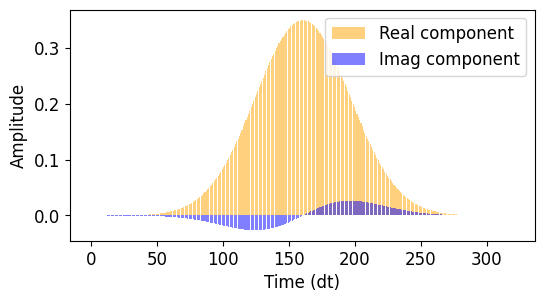

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3))

t_eval = jnp.linspace(0, total_length, total_length)

sq.visualization.plot_control_envelope(
    sq.control.get_waveform(params, control_sequence), t_eval, ax
)

## Perform experiment

Now, we are ready to perform an experiment on the quantum device. In this tutorial, we will use a local simulator to generate the data for us. In fact, most of the time, we might want to work on the local before performing experiment on the quantum device without confidence. 

Either ways, `inspeqtor` provides a unified and flexible pipeline for user to populate the data and store it with `ExperimentData` object. For now, let us shift our attention a bit to the quantum device simulator. 

As an example, we define our device as a single transmon qubit. We can also rotate the Hamiltonian with a frame as follows.

In [7]:
from functools import partial

signal_fn = sq.physics.signal_func_v4(
    get_envelope=control_sequence.get_envelope,
    drive_frequency=qubit_info.frequency,
    dt=dt,
)

hamiltonian = partial(
    sq.predefined.transmon_hamiltonian, qubit_info=qubit_info, signal=signal_fn
)
frame = (jnp.pi * qubit_info.frequency) * sq.constant.Z
hamiltonian = sq.physics.auto_rotating_frame_hamiltonian(hamiltonian, frame=frame)

Then, we can solve the Schrodinger equation using `sq.physics.solver`. By itself, `sq.physics.solver` is a function of multiple arguments that will solve the system dynamics on the call. But most of the time, we just want to solve the dynamics of the system with different control parameters, and keep the rest fixed. So the common pattern of using `sq.physics.solver` is to used it with `partial` as follows. 

In [8]:
solver = partial(
    sq.physics.solver,
    t_eval=t_eval * dt, # nanosecond.
    hamiltonian=hamiltonian,
    y0=jnp.eye(2, dtype=jnp.complex_),
    t0=0.0, # nanosecond.
    t1=total_length * dt, # nanosecond.
)

As per `inspeqtor` specification, the `hamiltonian` function required by `solver` should be a function of two arguments. The first argument can be arbitary while the second argument should be the a scalar of time. 

In [9]:
signal_params = sq.physics.SignalParametersV2(pulse_params=params, phase=0)
hamiltonian(signal_params, jnp.array(0))

Array([[0.00000000e+00+0.j, 1.06878303e-05+0.j],
       [1.06878303e-05+0.j, 0.00000000e+00+0.j]], dtype=complex128)

Now, we can solve the system dynamics by using the `solver` as a single argument function.

In [10]:
unitary = solver(signal_params)

We can visualize the trajectory of the system using the `visualization` module for quick inspection.

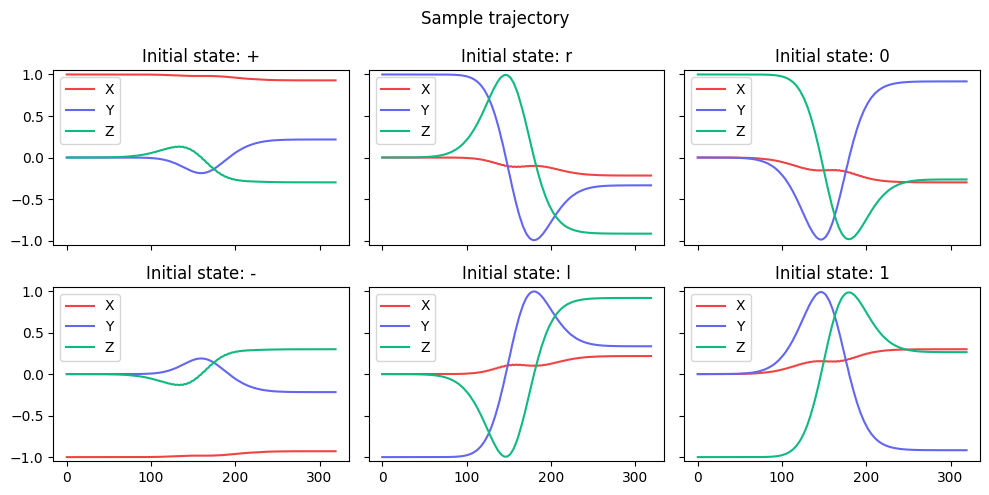

In [11]:
fig, axes = sq.visualization.plot_expectation_values(
    sq.visualization.format_expectation_values(
        sq.utils.calculate_expectation_values(unitary).T
    ),
    title="Sample trajectory",
)

We saw that by using `sq.physics.signal_func_v3` as a signal function wih the hamiltonian in the `predefined` module require using `sq.physics.SignalParameters` as the first argument for `solver`. The advantage of this approach is the explicitness of the control parameters. While it needs a lot of setup for it to working properly. 

Alternatively, we can use `sq.physics.signal_func_v5` which will results in an `jnp.array` as the first argument. This approach might be preferred for model training, vectorization, and compatability with other library. 

In [12]:
signal_fn = sq.physics.signal_func_v5(
    # We have to transform the usual envelope with helper function.
    get_envelope=sq.control.get_envelope_transformer(control_sequence),
    drive_frequency=qubit_info.frequency,
    dt=dt,
)

hamiltonian = partial(
    sq.predefined.transmon_hamiltonian, qubit_info=qubit_info, signal=signal_fn
)
hamiltonian = sq.physics.auto_rotating_frame_hamiltonian(hamiltonian, frame=frame)

solver = partial(
    sq.physics.solver,
    t_eval=t_eval * dt, # nanosecond.
    hamiltonian=hamiltonian,
    y0=jnp.eye(2, dtype=jnp.complex_),
    t0=0.0, # nanosecond.
    t1=total_length * dt, # nanosecond.
)

We also provide a helper function to convert the `list[ParameterDictType]` returned from the `sample_params` method to `jnp.narray` and vice versa.

In [13]:
ravel_fn, unravel_fn = sq.control.ravel_unravel_fn(control_sequence)
array_params = ravel_fn(params)
array_params

Array([ 4.3855351 , -4.46933642], dtype=float64)

In [14]:
reverted_params = unravel_fn(array_params)
reverted_params

{'drag': {'theta': Array(4.3855351, dtype=float64),
  'beta': Array(-4.46933642, dtype=float64)}}

Now, we can simply solve the system dynamics with `solver` and yield the same result.

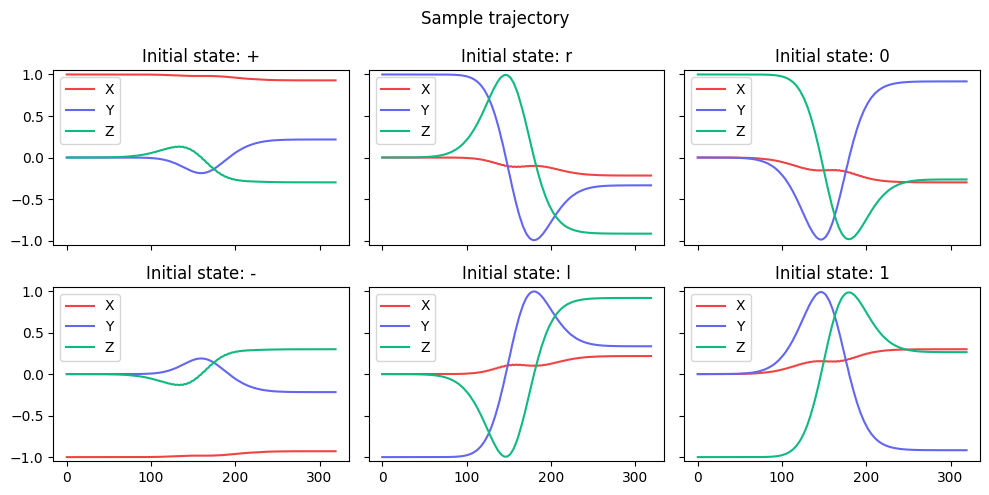

In [15]:
unitary_a = solver(array_params)

# Assert that they yield the same unitary 😎
assert jnp.allclose(unitary_a, unitary)

fig, axes = sq.visualization.plot_expectation_values(
    sq.visualization.format_expectation_values(
        sq.utils.calculate_expectation_values(unitary_a).T
    ),
    title="Sample trajectory",
)

What we can measure in the experiment is not the unitary, but the finite-shot expectation value. `inspeqtor` provides a helper function `sq.predefined.shot_quantum_device` to turn the solver into just that! Again, we use `partial` to fix the `solver` and the number `SHOTS`. Note that, it is up to user to decide the partial strategy to suit their use case. 

In [16]:
SHOTS = 1000
quantum_device = partial(
    sqe.utils.shot_quantum_device,
    solver=solver,
    SHOTS=SHOTS,
    expectation_value_receipt=sq.constant.default_expectation_values_order,
)

# Since, shot_quantum_device is a stochastic function, we have to provide the random key.
key, subkey = jax.random.split(key)
# Here the function accept a batch of control parameters, so we have to reshape it to have a batch dimension.
expvals = quantum_device(subkey, array_params.reshape(1, -1))
expvals

Array([[ 0.924, -0.91 , -0.17 ,  0.242, -0.272,  0.272,  0.216, -0.228,
        -0.368,  0.328,  0.896, -0.934, -0.26 ,  0.32 , -0.918,  0.922,
        -0.27 ,  0.266]], dtype=float64)

We saw that the output is an array of shape `(batch, 18)` where the number 18 is the complete combinatation of initial states and Pauli observables. The order of the expectation values array is order as the same as provided `expectation_value_receipt` argument. in this case, the order is the default order used throughout `inspeqtor`. 

It is important to note that, `inspeqtor` provide its functionality as functions so that user can provide a custom behavior by simply define function that have the same interface with the functions provided by `inspeqtor`. For example, `solver` that `sq.predefined.shot_quantum_device` is just a function of control parameters that return unitary at each time step as a result. Thus user can switch it out to user-defined solver such as physics-informed neural network. 

With the quantum device ready to use, we proceed with experimental data collection. To handle performing experiment in at once, in batch, or a single experiment at a time, we model each control parameter as a single row of the `pd.DataFrame` table (you can think of it as a sql table as well). Here we provide `sq.data.make_row` to enforce the schema. Let us see it in action by consider the experiment with initial state $|+\rangle$ and measure in $\hat{X}$ basis.

In [19]:
expectation_value_order = sq.data.get_complete_expectation_values(1)
exp = expectation_value_order[0]
exp

ExpectationValue(initial_state='+', observable='X', expectation_value=None)

Don't worry about `expectation_value = None`, since we merely use `ExpectationValue` in `sq.data.get_complete_expectation_values` for the code completion.

As a good practice, we will define experiment configuration first before performing the dataset as it is required later. However, user can do it after the experiment as appropiate.

In [ ]:
config = sq.data.ExperimentConfiguration(
    qubits=[qubit_info],
    expectation_values_order=expectation_value_order,
    parameter_structure=control_sequence.get_structure(),
    backend_name="red_demon",
    shots=SHOTS,
    EXPERIMENT_IDENTIFIER="0001",
    EXPERIMENT_TAGS=["tutorial", "for", "you", "😉"],
    description="One impossible step at a time",
    device_cycle_time_ns=dt,
    sequence_duration_dt=control_sequence.total_dt,
    instance="black_rose",
    sample_size=100,
)

Now, we proceed to perform a series of experiment and store the data in the `pd.DataFrame` instance as follows. First, we sample the control parameters and store them in a ready-to-use format.

In [20]:
sample_key = jax.random.key(0)
# Sample the parameter by vectorization.
params_dict = jax.vmap(control_sequence.sample_params)(
    jax.random.split(sample_key, config.sample_size)
)
# Prepare parameter in single line
params = jax.vmap(ravel_fn)(params_dict)

For simplicity, we perform experiments in a single batches.

In [22]:
device_key = jax.random.key(1)
# Perform experiment locally
expectation_values = quantum_device(device_key, params)
expectation_values.shape

(100, 18)

Next, we store the experimetal data 

In [25]:
import polars as pl
import numpy as np
from flax.traverse_util import flatten_dict

In [32]:
param_df = pl.DataFrame(
    jax.tree.map(lambda x: np.array(x), flatten_dict(params_dict, sep="/"))
).with_row_index("parameter_id")

obs_df = pl.DataFrame(
    jax.tree.map(
        lambda x: np.array(x),
        flatten_dict(sq.visualization.format_expectation_values(expectation_values.T), sep="/"),
    )
).with_row_index("parameter_id")

exp_data = sq.data.ExperimentalData(config, param_df, obs_df)

In [34]:
exp_data.parameter_dataframe

parameter_id,drag/beta,drag/theta
u32,f64,f64
0,-1.853182,1.629254
1,-4.469336,4.385535
2,-0.185842,1.522024
3,-1.735758,4.125283
4,4.564008,5.534084
…,…,…
95,2.640115,5.292947
96,1.480236,3.887745
97,-0.087796,2.371872


In [33]:
exp_data.observed_dataframe

parameter_id,+/X,+/Y,+/Z,-/X,-/Y,-/Z,0/X,0/Y,0/Z,1/X,1/Y,1/Z,l/X,l/Y,l/Z,r/X,r/Y,r/Z
u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,1.0,-0.044,-0.076,-1.0,0.044,0.006,0.014,-1.0,-0.058,0.016,0.998,0.064,-0.032,0.094,-0.998,0.05,-0.04,0.998
1,0.912,0.216,-0.314,-0.928,-0.266,0.316,-0.334,0.926,-0.282,0.296,-0.912,0.284,0.23,0.294,0.902,-0.182,-0.33,-0.914
2,1.0,-0.026,0.016,-1.0,0.042,-0.038,0.014,-1.0,0.094,0.022,0.996,-0.022,-0.024,-0.084,-1.0,0.04,0.006,0.998
3,0.994,0.036,-0.104,-0.986,-0.006,0.116,-0.072,0.858,-0.604,0.174,-0.828,0.51,0.092,0.56,0.854,0.0,-0.566,-0.818
4,0.906,-0.442,0.116,-0.914,0.39,-0.192,0.102,0.628,0.812,-0.146,-0.614,-0.772,-0.344,-0.67,0.676,0.374,0.7,-0.602
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
95,0.964,-0.224,0.064,-0.984,0.204,-0.12,0.08,0.81,0.538,-0.134,-0.832,-0.54,-0.214,-0.538,0.836,0.264,0.544,-0.82
96,0.998,-0.044,0.028,-0.992,0.028,-0.112,0.06,0.69,-0.75,-0.1,-0.668,0.708,-0.076,0.746,0.688,0.064,-0.756,-0.68
97,1.0,-0.02,0.006,-1.0,-0.01,0.024,0.004,-0.728,-0.718,0.046,0.692,0.724,0.016,0.7,-0.712,0.018,-0.676,0.676


Note that `exp_data.postprocessed_data` is a dataframe that created from the aggregation of the `exp_data.preprocess_data` by combinding rows with the same `parameters_id`. So the extra fields provided by the user will be just the first entry of the expectaion values combination.

## Save the experiment

There are several ways to save `sq.data.ExperimentData`. For the most common usage pattern, we provides a pair of save and load function in the `predefined` module. The `sq.predefined.save_data_to_path` function will save the dataset in the format that can be easily load back using `sq.predefined.load_data_from_path`.

In [35]:
import tempfile
from pathlib import Path

# path = Path("./test_data_v1")
tmpdir = tempfile.TemporaryDirectory()
path = Path(tmpdir.name)

# Create the path with parents if not existed already
path.mkdir(parents=True, exist_ok=True)
# Save the experiment with a single liner 😉.
sq.predefined.save_data_to_path(path, exp_data, control_sequence)

## Load the experiment
Loading just `sq.data.ExperimentData` back is often not enough. We load the data back into a bundle of `sq.utils.LoadedData` dataclass instance. The dataclass provides access to the `sq.data.ExperimentData`, `sq.control.ControlSequence`, `solver` with provided specification of Hamiltonian `sq.predefined.HamiltonianSpec` and the `jnp.ndarray` of control parameters, ideal unitary operators, and the corresponding expectation values. 

In [36]:
loaded_data = sq.predefined.load_data_from_path(
    path,
    hamiltonian_spec=sq.predefined.HamiltonianSpec(
        method=sqe.predefined.WhiteboxStrategy.TROTTER,
        trotter_steps=1_000,
    ),
)

tmpdir.cleanup()

Note that in the case of custom solver, user has to manually load the experimental dataset back by the primitive load method of `sq.data.ExperimentData` and solve for the unitary by the solver. User can also bundle the data by manually instantiate the `sq.utils.LoadedData` for further usage too.